In [2]:
import SimpleITK as sitk
import sys
import time
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def myshow(img, title=None, margin=0.05, dpi=80 ):
    nda = sitk.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    
    
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        
        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            nda = nda[nda.shape[0]//2,:,:]
    
    elif nda.ndim == 4:
        c = nda.shape[-1]
        
        if not c in (3,4):
            raise Runtime("Unable to show 3D-vector Image")
            
        # take a z-slice
        nda = nda[nda.shape[0]//2,:,:,:]
            
    ysize = nda.shape[0]
    xsize = nda.shape[1]
   
    
    # Make a figure big enough to accomodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    
    imgOrigin = np.array(img.GetOrigin())
    extent = (0+ imgOrigin[0], xsize*spacing[1]+ imgOrigin[0], ysize*spacing[0]+ imgOrigin[1], 0+ imgOrigin[1])
    print(extent)


    t = ax.imshow(nda,extent=extent,interpolation=None)
    
    if nda.ndim == 2:
        t.set_cmap("gray")
    
    if(title):
        plt.title(title)


In [4]:
# Read the original series. First obtain the series file names using the
# image series reader.
data_directory = './pCT_CT2_PhOK'
series_IDs = sitk.ImageSeriesReader.GetGDCMSeriesIDs(data_directory)
if not series_IDs:
    print(
        'ERROR: given directory "'
        + data_directory
        + '" does not contain a DICOM series.'
    )
    sys.exit(1)
series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(
    data_directory, series_IDs[0]
)

series_reader = sitk.ImageSeriesReader()
series_reader.SetFileNames(series_file_names)

In [5]:
series_reader.MetaDataDictionaryArrayUpdateOn()
series_reader.LoadPrivateTagsOn()
image3D = series_reader.Execute()


(-249.51171875, 250.48828125, 75.48828125, -424.51171875)


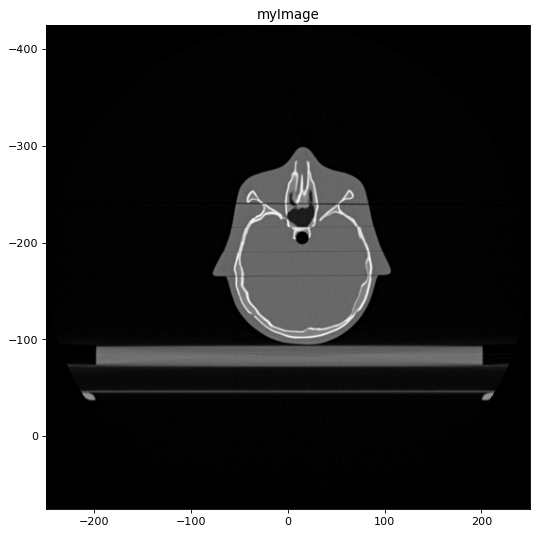

In [6]:
myshow(image3D[:,:,275], title="myImage")


In [7]:
m_Origin = np.array(image3D.GetOrigin())
m_Origin

array([ -249.51171875,  -424.51171875, -1222.        ])

In [8]:
m_Spacing = np.array(image3D.GetSpacing())
m_Spacing

array([0.9765625, 0.9765625, 1.       ])

In [9]:
m_Size = np.array(image3D.GetSize())
m_Size

array([512, 512, 476])

In [10]:
m_Orientation = np.reshape(image3D.GetDirection(),(3,3))
m_Orientation

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [11]:
m_Extent = (m_Size-1)*np.array(m_Spacing)
m_Extent

array([499.0234375, 499.0234375, 475.       ])

In [12]:
m_Last = np.array(m_Origin) + np.dot(m_Orientation , m_Extent)
m_Last

array([ 249.51171875,   74.51171875, -747.        ])

In [13]:
m_COV = np.array(m_Origin) + np.dot(m_Orientation , m_Extent/2)
m_COV

array([   0. , -175. , -984.5])

In [14]:
499.0234375/2

249.51171875

In [15]:
def win_scale(data, wl, ww, dtype, out_range):
    """
    Scale pixel intensity data using specified window level, width, and intensity range.
    """
    
    data_new = np.empty(data.shape, dtype=np.double)
    data_new.fill(out_range[1]-1)
    
    data_new[data <= (wl-ww/2.0)] = out_range[0]
    data_new[(data>(wl-ww/2.0))&(data<=(wl+ww/2.0))] = \
         ((data[(data>(wl-ww/2.0))&(data<=(wl+ww/2.0))]-(wl-0.5))/(ww-1.0)+0.5)*(out_range[1]-out_range[0])+out_range[0]
    data_new[data > (wl+ww/2.0)] = out_range[1]-1
    
    return data_new.astype(dtype)
        

In [16]:
nda = sitk.GetArrayFromImage(image3D)


In [52]:
ndaS = win_scale(nda,450,1500,'int16', np.array([-1024,3071]))

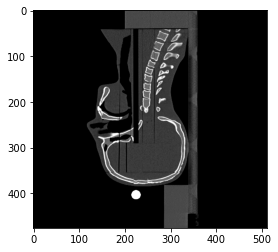

In [53]:
plt.imshow(ndaS[:,:,275],cmap='gray')


In [54]:
np.max(nda)

3071

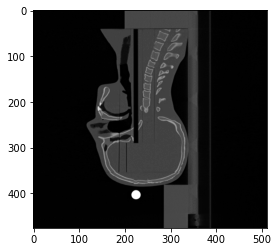

In [55]:
plt.imshow(nda[:,:,275],cmap='gray')


In [56]:
1024*3

3072

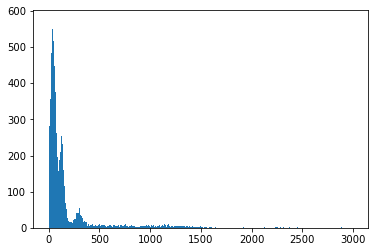

In [57]:
# calculate histogram
counts, bins = np.histogram(nda[:,:,275], range(3000))
# plot histogram centered on values 0..255
plt.bar(bins[:-1] - 0.5, counts, width=1, edgecolor='none')
#plt.xlim([-0.5, 255.5])
plt.show()

In [58]:
np.max(nda[:,:,275])

3071

(0.0, 10000.0)

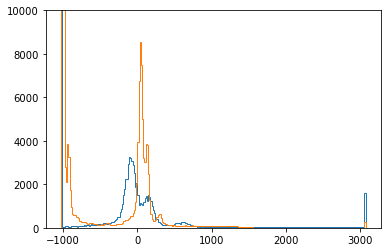

In [61]:
plt.hist(np.concatenate(ndaS[:,:,275]), bins=256, histtype='step');
plt.hist(np.concatenate(nda[:,:,275]), bins=256, histtype='step');

plt.ylim([0,10000])